## IMPORTS 

In [1]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch
from sklearn.preprocessing import LabelEncoder
#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

### Basic Parameters

In [2]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [3]:
data1 = pd.read_csv("../input/kuc-hackathon-winter-2018/drugsComTrain_raw.csv")

In [4]:
data2 = pd.read_csv("../input/kuc-hackathon-winter-2018/drugsComTest_raw.csv")

In [5]:
data = pd.concat([data1,data2])[['review','condition','rating']]

In [6]:
data.head()

,review,condition,rating
0,"""It has no side effect, I take it in combinati...",Left Ventricular Dysfunction,9
1,"""My son is halfway through his fourth week of ...",ADHD,8
2,"""I used to take another oral contraceptive, wh...",Birth Control,5
3,"""This is my first time using any form of birth...",Birth Control,8
4,"""Suboxone has completely turned my life around...",Opiate Dependence,9


In [7]:
# remove NULL Values from data
data = data[pd.notnull(data['review'])]

## Finding the maxlen

In [8]:
data['len'] = data['review'].apply(lambda s : len(s))

<Axes: ylabel='Frequency'>

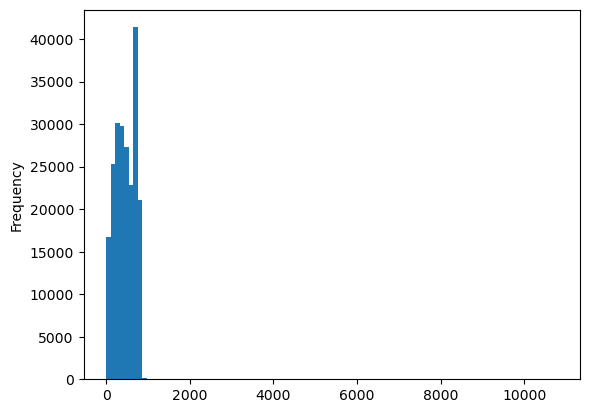

In [9]:
data['len'].plot.hist(bins=100)

In [10]:
data.len.quantile(0.9)

758.0

## Preprocessing Y Column
We are only going to be classifying conditions for which the count of reviews are more than 3000.

In [11]:
count_df = data[['condition','review']].groupby('condition').aggregate({'review':'count'}).reset_index().sort_values('review',ascending=False)
count_df.head()

,condition,review
175,Birth Control,38436
273,Depression,12164
613,Pain,8245
133,Anxiety,7812
87,Acne,7435


In [12]:
target_conditions = count_df[count_df['review']>3000]['condition'].values

In [13]:
def condition_parser(x):
    if x in target_conditions:
        return x
    else:
        return "OTHER"
    
data['condition'] = data['condition'].apply(lambda x: condition_parser(x))  

In [14]:
data = data[data['condition']!='OTHER']

In [15]:
import plotly.express as px

In [16]:
px.bar(count_df[count_df['review']>3000],x='condition',y='review')

In [17]:
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [18]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("this's a text with contraction")

'this is a text with contraction'

In [19]:
# lower the text
data["review"] = data["review"].apply(lambda x: x.lower())

# Clean the text
data["review"] = data["review"].apply(lambda x: clean_text(x))

# Clean numbers
data["review"] = data["review"].apply(lambda x: clean_numbers(x))

# Clean Contractions
data["review"] = data["review"].apply(lambda x: replace_contractions(x))


In [20]:
data['condition'].unique()

array(['ADHD', 'Birth Control', 'Emergency Contraception',
       'Bipolar Disorde', 'Depression', 'Obesity', 'Insomnia',
       'Vaginal Yeast Infection', 'Pain', 'Diabetes, Type 2', 'Anxiety',
       'Acne', 'High Blood Pressure', 'Weight Loss'], dtype=object)

In [21]:
data['sentiment'] = data["rating"].apply(lambda x: 1 if x > 5 else 0)

In [22]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(data, test_size = 0.25)

In [23]:
train_X = df_train['review']
test_X = df_test['review']

In [24]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (83673,)
Test shape :  (27891,)


In [25]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

### Load Embeddings


In [26]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

def load_glove(word_index):
    EMBEDDING_FILE = '../input/glove840b300dtxt/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [27]:
# missing entries in the embedding are set using np.random.normal so we have to seed here too

if debug:
    embedding_matrix = np.random.randn(120000,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



In [28]:
np.shape(embedding_matrix)

(30981, 300)

## Pytorch Model - TextCNN

In [29]:
class RegressionTrain(torch.nn.Module):

    def __init__(self, model,init_weight):
        super(RegressionTrain, self).__init__()

        self.model = model
        self.weights = torch.nn.Parameter(torch.from_numpy(init_weight).float())
        self.ce_loss = nn.CrossEntropyLoss()
        self.mse_loss = nn.MSELoss()

    def forward(self, x, ts):
        n_tasks = 2
        logit = self.model(x)
        task_loss = []

        task_loss.append(self.ce_loss(logit[0], ts[:, 0]))
        task_loss.append(self.ce_loss(logit[1], ts[:, 1]))

        task_loss = torch.stack(task_loss)

        return task_loss


class RegressionModel(torch.nn.Module):
    def __init__(self, n_tasks):
        super(RegressionModel, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        self.n_tasks = n_tasks
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        
        setattr(self, 'task_{}'.format(0), nn.Linear(len(filter_sizes)*num_filters, data.sentiment.nunique())) #2
        setattr(self, 'task_{}'.format(1), nn.Linear(len(filter_sizes)*num_filters, data.condition.nunique())) #num_classes


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        
        outs = []
        for i in range(self.n_tasks):
            layer = getattr(self, 'task_{}'.format(i))
            outs.append(layer(x))

        return outs

In [30]:
def data_make(df_train, df_test):
    le = LabelEncoder()
    batch_size = 256
    

    train_label2 = le.fit_transform(df_train['condition'].values)[:, np.newaxis]
    # train_label2 = tf.keras.utils.to_categorical(train_label2, num_classes=num_classes)
    # val_label2 = tf.keras.utils.to_categorical(val_label2, num_classes=num_classes)
    test_label2 = le.transform(df_test['condition'].values)[:, np.newaxis]
    #test_label2 = tf.keras.utils.to_categorical(test_label2, num_classes=num_classes)


    # train_label1 = tf.keras.utils.to_categorical(df_train['sentiment'].values[:, np.newaxis], num_classes=2)
    # val_label1 = tf.keras.utils.to_categorical(df_val['sentiment'].values[:, np.newaxis], num_classes=2)
    # test_label1 = tf.keras.utils.to_categorical(df_test['sentiment'].values[:, np.newaxis], num_classes=2)

    train_label1 = df_train['sentiment'].values[:, np.newaxis]
    test_label1 = df_test['sentiment'].values[:, np.newaxis]

    train_Y = np.concatenate((train_label1, train_label2), axis=1)
    test_Y = np.concatenate((test_label1, test_label2), axis=1)

    x_train = torch.from_numpy(train_X).long().cuda()
    y_train = torch.from_numpy(train_Y).long().cuda()
    x_test = torch.from_numpy(test_X).long().cuda()
    y_test = torch.from_numpy(test_Y).long().cuda()

    # Create Torch datasets
    train = torch.utils.data.TensorDataset(x_train, y_train)
    test = torch.utils.data.TensorDataset(x_test, y_test)
    # Create Data Loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
   
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

## Train TextCNN Model

In [31]:
# This code is from
# Multi-Task Learning as Multi-Objective Optimization
# Ozan Sener, Vladlen Koltun
# Neural Information Processing Systems (NeurIPS) 2018
# https://github.com/intel-isl/MultiObjectiveOptimization

import numpy as np
import torch


class MinNormSolver:
    MAX_ITER = 250
    STOP_CRIT = 1e-5

    def _min_norm_element_from2(v1v1, v1v2, v2v2):
        """
        Analytical solution for min_{c} |cx_1 + (1-c)x_2|_2^2
        d is the distance (objective) optimzed
        v1v1 = <x1,x1>
        v1v2 = <x1,x2>
        v2v2 = <x2,x2>
        """
        if v1v2 >= v1v1:
            # Case: Fig 1, third column
            gamma = 0.999
            cost = v1v1
            return gamma, cost
        if v1v2 >= v2v2:
            # Case: Fig 1, first column
            gamma = 0.001
            cost = v2v2
            return gamma, cost
        # Case: Fig 1, second column
        gamma = -1.0 * ( (v1v2 - v2v2) / (v1v1+v2v2 - 2*v1v2) )
        cost = v2v2 + gamma*(v1v2 - v2v2)
        return gamma, cost

    def _min_norm_2d(vecs, dps):
        """
        Find the minimum norm solution as combination of two points
        This is correct only in 2D
        ie. min_c |\sum c_i x_i|_2^2 st. \sum c_i = 1 , 1 >= c_1 >= 0 for all i, c_i + c_j = 1.0 for some i, j
        """
        dmin = 1e8
        for i in range(len(vecs)):
            for j in range(i+1,len(vecs)):
                if (i,j) not in dps:
                    dps[(i, j)] = 0.0
                    for k in range(len(vecs[i])):
                        dps[(i,j)] += torch.dot(vecs[i][k], vecs[j][k]).item()#torch.dot(vecs[i][k], vecs[j][k]).data[0]
                    dps[(j, i)] = dps[(i, j)]
                if (i,i) not in dps:
                    dps[(i, i)] = 0.0
                    for k in range(len(vecs[i])):
                        dps[(i,i)] += torch.dot(vecs[i][k], vecs[i][k]).item()#torch.dot(vecs[i][k], vecs[i][k]).data[0]
                if (j,j) not in dps:
                    dps[(j, j)] = 0.0
                    for k in range(len(vecs[i])):
                        dps[(j, j)] += torch.dot(vecs[j][k], vecs[j][k]).item()#torch.dot(vecs[j][k], vecs[j][k]).data[0]
                c,d = MinNormSolver._min_norm_element_from2(dps[(i,i)], dps[(i,j)], dps[(j,j)])
                if d < dmin:
                    dmin = d
                    sol = [(i,j),c,d]
        return sol, dps

    def _projection2simplex(y):
        """
        Given y, it solves argmin_z |y-z|_2 st \sum z = 1 , 1 >= z_i >= 0 for all i
        """
        m = len(y)
        sorted_y = np.flip(np.sort(y), axis=0)
        tmpsum = 0.0
        tmax_f = (np.sum(y) - 1.0)/m
        for i in range(m-1):
            tmpsum+= sorted_y[i]
            tmax = (tmpsum - 1)/ (i+1.0)
            if tmax > sorted_y[i+1]:
                tmax_f = tmax
                break
        return np.maximum(y - tmax_f, np.zeros(y.shape))

    def _next_point(cur_val, grad, n):
        proj_grad = grad - ( np.sum(grad) / n )
        tm1 = -1.0*cur_val[proj_grad<0]/proj_grad[proj_grad<0]
        tm2 = (1.0 - cur_val[proj_grad>0])/(proj_grad[proj_grad>0])

        skippers = np.sum(tm1<1e-7) + np.sum(tm2<1e-7)
        t = 1
        if len(tm1[tm1>1e-7]) > 0:
            t = np.min(tm1[tm1>1e-7])
        if len(tm2[tm2>1e-7]) > 0:
            t = min(t, np.min(tm2[tm2>1e-7]))

        next_point = proj_grad*t + cur_val
        next_point = MinNormSolver._projection2simplex(next_point)
        return next_point

    def find_min_norm_element(vecs):
        """
        Given a list of vectors (vecs), this method finds the minimum norm element in the convex hull
        as min |u|_2 st. u = \sum c_i vecs[i] and \sum c_i = 1.
        It is quite geometric, and the main idea is the fact that if d_{ij} = min |u|_2 st u = c x_i + (1-c) x_j; the solution lies in (0, d_{i,j})
        Hence, we find the best 2-task solution, and then run the projected gradient descent until convergence
        """
        # Solution lying at the combination of two points
        dps = {}
        init_sol, dps = MinNormSolver._min_norm_2d(vecs, dps)

        n=len(vecs)
        sol_vec = np.zeros(n)
        sol_vec[init_sol[0][0]] = init_sol[1]
        sol_vec[init_sol[0][1]] = 1 - init_sol[1]

        if n < 3:
            # This is optimal for n=2, so return the solution
            return sol_vec , init_sol[2]

        iter_count = 0

        grad_mat = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                grad_mat[i,j] = dps[(i, j)]


        while iter_count < MinNormSolver.MAX_ITER:
            grad_dir = -1.0*np.dot(grad_mat, sol_vec)
            new_point = MinNormSolver._next_point(sol_vec, grad_dir, n)
            # Re-compute the inner products for line search
            v1v1 = 0.0
            v1v2 = 0.0
            v2v2 = 0.0
            for i in range(n):
                for j in range(n):
                    v1v1 += sol_vec[i]*sol_vec[j]*dps[(i,j)]
                    v1v2 += sol_vec[i]*new_point[j]*dps[(i,j)]
                    v2v2 += new_point[i]*new_point[j]*dps[(i,j)]
            nc, nd = MinNormSolver._min_norm_element_from2(v1v1, v1v2, v2v2)
            new_sol_vec = nc*sol_vec + (1-nc)*new_point
            change = new_sol_vec - sol_vec
            if np.sum(np.abs(change)) < MinNormSolver.STOP_CRIT:
                return sol_vec, nd
            sol_vec = new_sol_vec

    def find_min_norm_element_FW(vecs):
        """
        Given a list of vectors (vecs), this method finds the minimum norm element in the convex hull
        as min |u|_2 st. u = \sum c_i vecs[i] and \sum c_i = 1.
        It is quite geometric, and the main idea is the fact that if d_{ij} = min |u|_2 st u = c x_i + (1-c) x_j; the solution lies in (0, d_{i,j})
        Hence, we find the best 2-task solution, and then run the Frank Wolfe until convergence
        """
        # Solution lying at the combination of two points
        dps = {}
        init_sol, dps = MinNormSolver._min_norm_2d(vecs, dps)

        n=len(vecs)
        sol_vec = np.zeros(n)
        sol_vec[init_sol[0][0]] = init_sol[1]
        sol_vec[init_sol[0][1]] = 1 - init_sol[1]

        if n < 3:
            # This is optimal for n=2, so return the solution
            return sol_vec , init_sol[2]

        iter_count = 0

        grad_mat = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                grad_mat[i,j] = dps[(i, j)]

        while iter_count < MinNormSolver.MAX_ITER:
            t_iter = np.argmin(np.dot(grad_mat, sol_vec))

            v1v1 = np.dot(sol_vec, np.dot(grad_mat, sol_vec))
            v1v2 = np.dot(sol_vec, grad_mat[:, t_iter])
            v2v2 = grad_mat[t_iter, t_iter]

            nc, nd = MinNormSolver._min_norm_element_from2(v1v1, v1v2, v2v2)
            new_sol_vec = nc*sol_vec
            new_sol_vec[t_iter] += 1 - nc

            change = new_sol_vec - sol_vec
            if np.sum(np.abs(change)) < MinNormSolver.STOP_CRIT:
                return sol_vec, nd
            sol_vec = new_sol_vec


def gradient_normalizers(grads, losses, normalization_type):
    gn = {}
    if normalization_type == 'l2':
        for t in grads:
            gn[t] = np.sqrt(np.sum([gr.pow(2).sum().data[0] for gr in grads[t]]))
    elif normalization_type == 'loss':
        for t in grads:
            gn[t] = losses[t]
    elif normalization_type == 'loss+':
        for t in grads:
            gn[t] = losses[t] * np.sqrt(np.sum([gr.pow(2).sum().data[0] for gr in grads[t]]))
    elif normalization_type == 'none':
        for t in grads:
            gn[t] = 1.0
    else:
        print('ERROR: Invalid Normalization Type')
    return gn

In [32]:
def get_d_paretomtl_init(grads,value,weights,i):
    """
    calculate the gradient direction for ParetoMTL initialization
    """

    flag = False
    nobj = value.shape

    # check active constraints
    current_weight = weights[i]
    rest_weights = weights
    w = rest_weights - current_weight

    gx =  torch.matmul(w,value/torch.norm(value))
    idx = gx >  0

    # calculate the descent direction
    if torch.sum(idx) <= 0:
        flag = True
        return flag, torch.zeros(nobj)
    if torch.sum(idx) == 1:
        sol = torch.ones(1).cuda().float()
    else:
        vec =  torch.matmul(w[idx],grads)
        sol, nd = MinNormSolver.find_min_norm_element([[vec[t]] for t in range(len(vec))])


    weight0 =  torch.sum(torch.stack([sol[j] * w[idx][j ,0] for j in torch.arange(0, torch.sum(idx))]))
    weight1 =  torch.sum(torch.stack([sol[j] * w[idx][j ,1] for j in torch.arange(0, torch.sum(idx))]))
    weight = torch.stack([weight0,weight1])


    return flag, weight


def get_d_paretomtl(grads,value,weights,i):
    """ calculate the gradient direction for ParetoMTL """

    # check active constraints
    current_weight = weights[i]
    rest_weights = weights
    w = rest_weights - current_weight

    gx =  torch.matmul(w,value/torch.norm(value))
    idx = gx >  0


    # calculate the descent direction
    if torch.sum(idx) <= 0:
        sol, nd = MinNormSolver.find_min_norm_element([[grads[t]] for t in range(len(grads))])
        return torch.tensor(sol).cuda().float()


    vec =  torch.cat((grads, torch.matmul(w[idx],grads)))
    sol, nd = MinNormSolver.find_min_norm_element([[vec[t]] for t in range(len(vec))])


    weight0 =  sol[0] + torch.sum(torch.stack([sol[j] * w[idx][j - 2 ,0] for j in torch.arange(2, 2 + torch.sum(idx))]))
    weight1 =  sol[1] + torch.sum(torch.stack([sol[j] * w[idx][j - 2 ,1] for j in torch.arange(2, 2 + torch.sum(idx))]))
    weight = torch.stack([weight0,weight1])

    return weight


def circle_points(r, n):
    """
    generate evenly distributed unit preference vectors for two tasks
    """
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 0.5 * np.pi, n)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles

In [33]:
def train(base_model, niter, npref, init_weight, pref_idx, sigma = 5*1e-1, k = 0.95, Lr = 1e-2):

    # generate #npref preference vectors
    n_tasks = 2
    ref_vec = torch.tensor(circle_points([1], [npref])[0]).cuda().float()

    # load dataset
    train_loader, test_loader = data_make(df_train, df_test)

    print('==>>> total trainning batch number: {}'.format(len(train_loader)))
    print('==>>> total testing batch number: {}'.format(len(test_loader)))


      # define the base model for ParetoMTL
    if base_model == 'lenet':
        model = RegressionTrain(RegressionModel(n_tasks), init_weight)
    if base_model == 'resnet18':
        model = RegressionTrainResNet(MnistResNet(n_tasks), init_weight)

    # choose different optimizer for different base model
    if base_model == 'lenet':
        optimizer = torch.optim.SGD(model.parameters(), lr= Lr, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15,30,45,60,75,90], gamma=0.5)

    if base_model == 'resnet18':
        optimizer = torch.optim.Adam(model.parameters(), lr= Lr)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.1)
    
    if torch.cuda.is_available():
        model.cuda()

    model.model.embedding.requires_grad_(False)
   
    # store infomation during optimization
    weights = []
    task_train_losses = []
    train_accs = []
    task_test_losses = []
    test_accs = []
    learning_rate = []

    # print the current preference vector
    print('Preference Vector ({}/{}):'.format(pref_idx + 1, npref))
    print(ref_vec[pref_idx].cpu().numpy())
    learning_rate.append(Lr)
    # run at most 2 epochs to find the initial solution
    # stop early once a feasible solution is found
    # usually can be found with a few steps
    for t in range(2):

        model.train()
        for (it, batch) in enumerate(train_loader):
            X = batch[0]
            ts = batch[1]
            if torch.cuda.is_available():
                X = X.cuda()
                ts = ts.cuda()

            grads = {}
            losses_vec = []


            # obtain and store the gradient value
            for i in range(n_tasks):
                optimizer.zero_grad()
                task_loss = model(X, ts)
                losses_vec.append(task_loss[i].data)

                task_loss[i].backward()

                grads[i] = []

                # can use scalable method proposed in the MOO-MTL paper for large scale problem
                # but we keep use the gradient of all parameters in this experiment
                for param in model.parameters():
                    if param.grad is not None:
                        grads[i].append(Variable(param.grad.data.clone().flatten(), requires_grad=False))



            grads_list = [torch.cat(grads[i]) for i in range(len(grads))]
            grads = torch.stack(grads_list)

            # calculate the weights
            losses_vec = torch.stack(losses_vec)
            flag, weight_vec = get_d_paretomtl_init(grads,losses_vec,ref_vec,pref_idx)

            # early stop once a feasible solution is obtained
            if flag == True:
                print("fealsible solution is obtained.")
                break

            # optimization step
            optimizer.zero_grad()
            for i in range(len(task_loss)):
                task_loss = model(X, ts)
                if i == 0:
                    loss_total = weight_vec[i] * task_loss[i]
                else:
                    loss_total = loss_total + weight_vec[i] * task_loss[i]

            loss_total.backward()
            optimizer.step()

        else:
        # continue if no feasible solution is found
            continue
        # break the loop once a feasible solutions is found
        break



    # run niter epochs of ParetoMTL
    for t in range(niter):

        model.train()
        
        e = 0
        loss_total_full = 0
        loss_total_after_full = 0
        
        for (it, batch) in enumerate(train_loader):

            X = batch[0]
            ts = batch[1]
            if torch.cuda.is_available():
                X = X.cuda()
                ts = ts.cuda()

            # obtain and store the gradient
            grads = {}
            losses_vec = []

            for i in range(n_tasks):
                optimizer.zero_grad()
                task_loss = model(X, ts)
                losses_vec.append(task_loss[i].data)

                task_loss[i].backward()

                # can use scalable method proposed in the MOO-MTL paper for large scale problem
                # but we keep use the gradient of all parameters in this experiment
                grads[i] = []
                for param in model.parameters():
                    if param.grad is not None:
                        grads[i].append(Variable(param.grad.data.clone().flatten(), requires_grad=False))



            grads_list = [torch.cat(grads[i]) for i in range(len(grads))]
            grads = torch.stack(grads_list)

            # calculate the weights
            losses_vec = torch.stack(losses_vec)
            weight_vec = get_d_paretomtl(grads,losses_vec,ref_vec,pref_idx)

            normalize_coeff = n_tasks / torch.sum(torch.abs(weight_vec))
            weight_vec = weight_vec * normalize_coeff

            # optimization step
            optimizer.zero_grad()
            for i in range(len(task_loss)):
                task_loss = model(X, ts)
                if i == 0:
                    loss_total = weight_vec[i] * task_loss[i]
                else:
                    loss_total = loss_total + weight_vec[i] * task_loss[i]
                    
            loss_total_full += loss_total.item()
            loss_total.backward()
            
            for p in model.parameters():
                if p.requires_grad is False:
                    continue
                dp = p.grad
                if dp == None:
                    continue
                p_pre = p.data.clone()
                p.data -= Lr*dp
                e += torch.matmul(dp.flatten(),(p_pre.data - p.data).flatten())
            
            #GDA Hyper-param  ==== optimizer.step()
            optimizer.zero_grad()
            
            for i in range(len(task_loss)):
                task_loss_after = model(X, ts)
                if i == 0:
                    loss_total_after = weight_vec[i] * task_loss_after[i]
                else:
                    loss_total_after = loss_total_after + weight_vec[i] * task_loss_after[i]
            loss_total_after_full += loss_total_after.item()
            
#             print(loss_total_after - loss_total + sigma*e)
#             if loss_total_after - loss_total + sigma*e <=0:
#                 Lr = Lr
#             else:
#                 print('Learning rate gets updated')
#                 Lr = k*Lr
        
#         print(loss_total_after_full - loss_total_full)
#         print(sigma*e)
        if  loss_total_after_full - loss_total_full + sigma*(e) <= 0:
            Lr = Lr
        else:
            print('Learning rate gets updated')
            Lr = k*Lr
        learning_rate.append(Lr)
        # calculate and record performance
        if t == 0 or (t + 1) % 2 == 0:

            model.eval()
            with torch.no_grad():

                total_train_loss = []
                train_acc = []

                correct1_train = 0
                correct2_train = 0

                for (it, batch) in enumerate(train_loader):

                    X = batch[0]
                    ts = batch[1]
                    if torch.cuda.is_available():
                        X = X.cuda()
                        ts = ts.cuda()

                    valid_train_loss = model(X, ts)
                    total_train_loss.append(valid_train_loss)
                    output1 = model.model(X)[0].max(1, keepdim=True)[1]
                    output2 = model.model(X)[1].max(1, keepdim=True)[1]
                    correct1_train += output1.eq(ts[:,0].view_as(output1)).sum().item()
                    correct2_train += output2.eq(ts[:,1].view_as(output2)).sum().item()


                train_acc = np.stack([1.0 * correct1_train / len(train_loader.dataset),1.0 * correct2_train / len(train_loader.dataset)])

                total_train_loss = torch.stack(total_train_loss)
                average_train_loss = torch.mean(total_train_loss, dim = 0)

                total_test_loss = []
                test_acc = []

                correct1_test = 0
                correct2_test = 0

                for (it, batch) in enumerate(test_loader):

                    X = batch[0]
                    ts = batch[1]
                    if torch.cuda.is_available():
                        X = X.cuda()
                        ts = ts.cuda()

                    valid_test_loss = model(X, ts)
                    total_test_loss.append(valid_test_loss)
                    output1 = model.model(X)[0].max(1, keepdim=True)[1]
                    output2 = model.model(X)[1].max(1, keepdim=True)[1]
                    correct1_test += output1.eq(ts[:,0].view_as(output1)).sum().item()
                    correct2_test += output2.eq(ts[:,1].view_as(output2)).sum().item()


                test_acc = np.stack([1.0 * correct1_test / len(test_loader.dataset),1.0 * correct2_test / len(test_loader.dataset)])

                total_test_loss = torch.stack(total_test_loss)
                average_test_loss = torch.mean(total_test_loss, dim = 0)
            # record and print
            if torch.cuda.is_available():

                task_train_losses.append(average_train_loss.data.cpu().numpy())
                train_accs.append(train_acc)

                task_test_losses.append(average_test_loss.data.cpu().numpy())
                test_accs.append(test_acc)
                weights.append(weight_vec.cpu().numpy())

                print('{}/{}: weights={}, train_loss={}, train_acc={}, test_loss={}, test_acc={}'.format(
                        t + 1, niter,  weights[-1], task_train_losses[-1],train_accs[-1], task_test_losses[-1], test_accs[-1]))


    torch.save(model.model.state_dict(), '/kaggle/working//%s_niter_%d_npref_%d_prefidx_%d.pickle'%(base_model, niter, npref, pref_idx))

    return task_train_losses, train_accs, task_test_losses, test_accs, learning_rate

In [34]:
def run(dataset = 'fashion_and_mnist', base_model = 'resnet18', niter = 100, npref = 20):
    """
    run Pareto MTL
    """

    init_weight = np.array([0.5 , 0.5 ])
    task_train_losses_pref = []
    train_accs_pref = []
    task_test_losses_pref = []
    test_accs_pref = []
    learning_rate_pref = []

    for i in range(npref):

        pref_idx = i
        task_train_losses, train_accs, task_test_losses, test_accs, learning_rate = train(base_model, niter, npref, init_weight, pref_idx)
        task_train_losses_pref.append(task_train_losses)
        train_accs_pref.append(train_accs)
        task_test_losses_pref.append(task_test_losses)
        test_accs_pref.append(test_accs)
        learning_rate_pref.append(learning_rate)

    return  task_train_losses_pref, train_accs_pref, task_test_losses_pref, test_accs_pref, learning_rate_pref

In [35]:
task_train_losses_pref, train_accs_pref, task_test_losses_pref, test_accs_pref, learning_rate_pref = run(dataset = 'mnist', base_model = 'lenet', niter = 50, npref = 5)

==>>> total trainning batch number: 327
==>>> total testing batch number: 109
Preference Vector (1/5):
[1. 0.]
fealsible solution is obtained.
1/50: weights=[0.00512262 1.9948773 ], train_loss=[7.7462263 1.4331763], train_acc=[0.31997179 0.53493959], test_loss=[7.7442284 1.4327154], test_acc=[0.32010326 0.53343372]
2/50: weights=[0.00734458 1.9926554 ], train_loss=[5.3692646 1.0478305], train_acc=[0.31997179 0.64025432], test_loss=[5.3678403 1.0475608], test_acc=[0.32010326 0.64264458]
4/50: weights=[0.00212916 1.9978708 ], train_loss=[3.0135107 0.6790109], train_acc=[0.31997179 0.79456934], test_loss=[3.0128531  0.68150634], test_acc=[0.32010326 0.79416299]
6/50: weights=[0.00862109 1.9913788 ], train_loss=[1.4992015  0.55278397], train_acc=[0.31997179 0.82638366], test_loss=[1.4995078  0.55701184], test_acc=[0.32010326 0.82345559]
8/50: weights=[0.7245668 1.2754332], train_loss=[0.60359704 0.5033662 ], train_acc=[0.68115163 0.83705616], test_loss=[0.6038355 0.5092526], test_acc=[0.68